## Importations de package

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from PIL import Image,ImageDraw
import skimage.morphology as morpho
from skimage.segmentation import watershed,mark_boundaries
import scipy.spatial as sp

## Gradient morphologique

Text(0.5, 1.0, 'Gradient morphologique')

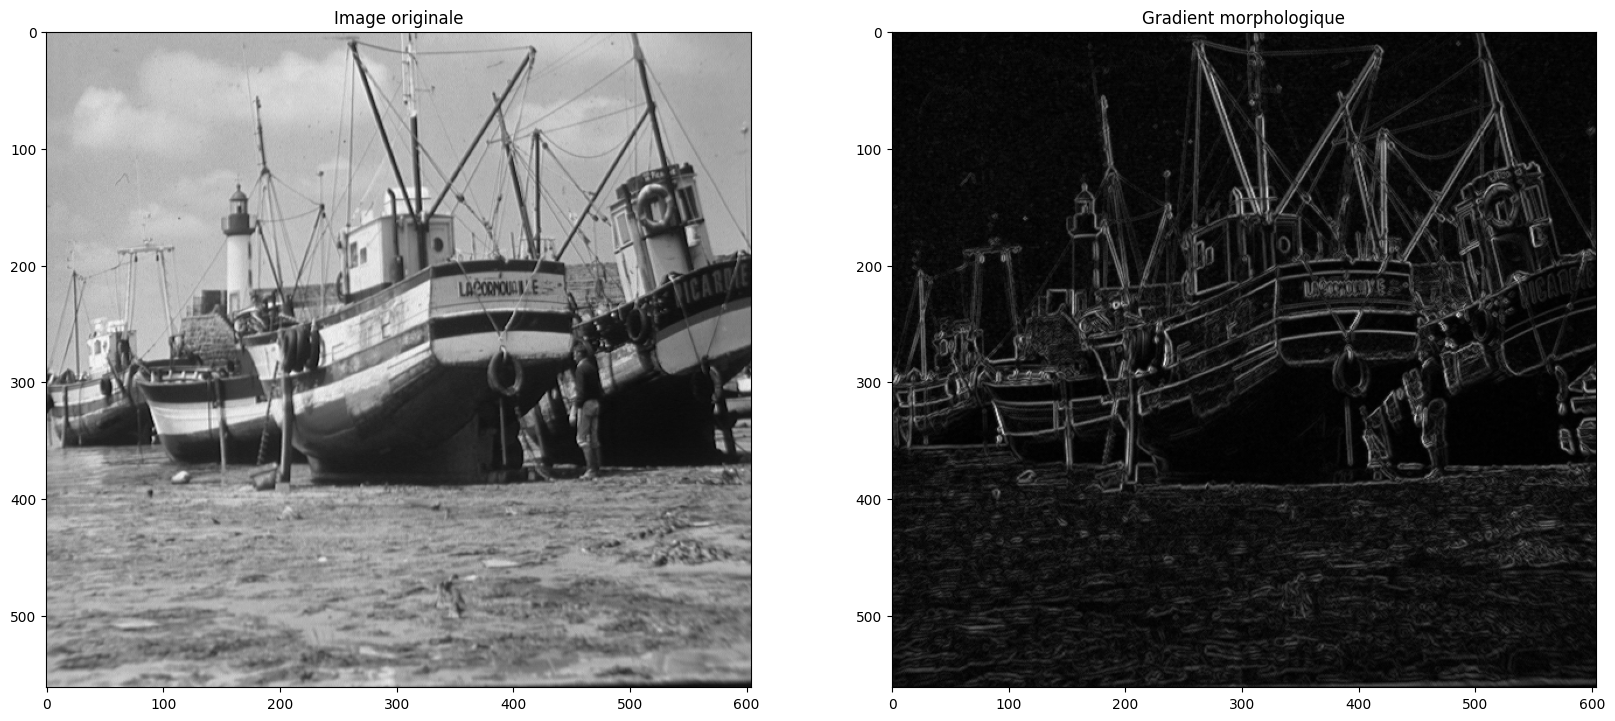

In [3]:
img = io.imread('images/bat.tif')



def gradmorpho(img):

    se = morpho.disk(1)
    morpho_grad = morpho.dilation(img,se) - morpho.erosion(img, se)

    return morpho_grad

grad_morpho = gradmorpho(img)

fig,ax = plt.subplots(1,2,figsize = (20,15))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image originale')
ax[1].imshow(grad_morpho,cmap = "gray")
ax[1].set_title('Gradient morphologique')


## Cellules hexagonales

In [4]:
def calcul_hexa_centers(img,taille):
    colonnes, lignes = img.size
    hexa_centers = []
    p_horizontal=3*taille*0.5
    p_vertical=np.sqrt(3)*taille
    I = int(colonnes/p_horizontal) + 2 #I est le nombre de centres par ligne
    J = int(lignes/p_vertical) + 2 #J est le nombre de centres par colonne
    for i in range(I):
        for j in range(J):
            if i%2==0:
                hexa_centers.append((int(i*p_horizontal) ,int(j*p_vertical)))
            else:
                hexa_centers.append((int(i*p_horizontal),int((j*p_vertical)+p_vertical/2)))
    return hexa_centers

"""
hexa_centers = calcul_hexa_centers(img,10)
lignes, colonnes = img.shape
img_test = np.zeros((lignes,colonnes))+255
for center in hexa_centers:
    #if center[0]<lignes and center[1]<colonnes:
    img_test[center[0]][center[1]] = 0
plt.imshow(img_test,cmap='gray')
print(hexa_centers)
#hexa_contours = np.zeros((lignes,colonnes,1))
"""


"\nhexa_centers = calcul_hexa_centers(img,10)\nlignes, colonnes = img.shape\nimg_test = np.zeros((lignes,colonnes))+255\nfor center in hexa_centers:\n    #if center[0]<lignes and center[1]<colonnes:\n    img_test[center[0]][center[1]] = 0\nplt.imshow(img_test,cmap='gray')\nprint(hexa_centers)\n#hexa_contours = np.zeros((lignes,colonnes,1))\n"

In [5]:
def hexa_sommets(centre, t, rho):
    x,y = centre
    taille= t*rho
    return [(x+taille,y),
            (x+(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-taille,y),
            (x-(taille/2),y-(taille*np.sqrt(3)/2)),
            (x+(taille/2),y-(taille*np.sqrt(3)/2))
            ]


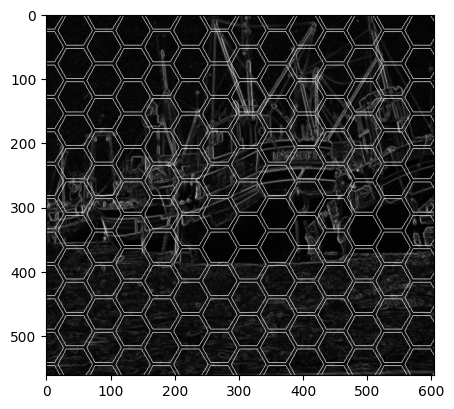

In [6]:
def hexagon(img, taille, rho):
    img_grid = img.copy()
    draw = ImageDraw.Draw(img_grid)
    hexa_centers = calcul_hexa_centers(img,taille)

    for c in hexa_centers:
        p = hexa_sommets(c, taille, rho)
        draw.polygon((p),outline="white")

    return img_grid

im = Image.fromarray(np.uint8(grad_morpho))
hexa = hexagon(im,30,0.9)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(hexa, cmap='gray')


## Sélection des marqueurs

In [7]:
def point_dans_hexagon(centre,point,taille):
    x,y = point[0]-centre[0],point[1]-centre[1]
    distance = math.sqrt((x**2)+(y**2))
    if distance > 0:
        theta = math.acos(x/distance)
        theta = theta%(np.pi/3)
        distance_max=0
        if(theta<=np.pi/6):
            distance_max = taille*((((math.sqrt(3)*0.5)-1)*6*theta/np.pi)+1)
        else:
            distance_max = taille*(6*theta*(1-(math.sqrt(3)*0.5))/np.pi)+math.sqrt(3)-1
        return distance <= distance_max
    else:
        return True

In [8]:
def extract_hex_points(centre,taille):
    square = []
    hex=[]
    for x in range(-taille,taille):
        for y in range(-taille,taille):
            square.append((centre[0]+x,centre[1]+y))
    for s in square:
        if(point_dans_hexagon(centre,s,taille)):
            hex.append(s)
    return hex

In [23]:
def extract_hex_grad_min(grad_im,c,taille):
    hex_points = extract_hex_points(c,taille)
    grad_hex = []
    grad_coord = []
    lignes, colonnes = grad_im.size
    for p in hex_points:
        if (p[0]>=0 and p[0]<lignes and p[1]>=0 and p[1]<colonnes):
            grad_hex.append(grad_im.getpixel((p[0],p[1])))
            grad_coord.append((p[0],p[1]))
    grad_hex = np.array(grad_hex)
    if len(grad_hex)>0:
        min_indices = np.where(grad_hex == grad_hex.min())[0]
        min_grad = [grad_hex[i] for i in min_indices]
        min_coord = [grad_coord[i] for i in min_indices]
        return min_grad, min_coord
    else:
        return 0, [c]
extract_hex_grad_min(im,(0,0),30)

([1, 1, 1, 1], [(1, 14), (16, 3), (16, 6), (17, 3)])

In [17]:
## A réécrire
def selection_marqueurs(grad_im,taille):
    marqueurs = []
    for c in calcul_hexa_centers(grad_im,taille):
        min_grad, min_coord = extract_hex_grad_min(grad_im,c,taille)
        if len(grad_hex)>0:
            min_indices = np.where(grad_hex == grad_hex.min())[0]
            groupes_grad = [[i] for i in min_indices]
            for i1 in range(len(min_indices)):
                for i2 in range(len(min_indices)):
                    coord1 = grad_coord[min_indices[i1]]
                    coord2 = grad_coord[min_indices[i2]]
                    if coord1[0]==coord2[0]+1 or coord1[0]==coord2[0]-1 or coord1[0]==coord2[0]:
                        if coord1[1]==coord2[1]+1 or coord1[1]==coord2[1]-1 or coord1[1]==coord2[1]:
                            if min_indices[i2] not in groupes_grad[i1]:
                                groupes_grad[i1].append(min_indices[i2])
            len_max = max([len(i) for i in groupes_grad])
            for i in groupes_grad:
                if len(i)==len_max:
                    groupe_grad_max = i
                    break
            position_marqueur = [(grad_coord[i]) for i in groupe_grad_max]
            marqueurs.append(position_marqueur)
        else:
            marqueurs.append([c])
    return marqueurs
s=[]
for c in calcul_hexa_centers(im,int(30*0.9)):
    s.append(extract_hex_grad_min(im,c,int(30*0.9)))
print(s)
"""
len_max = max([len(i) for i in s])
for i in s:
    if len(i)==len_max:
        print(i)
"""
colonnes,lignes = im.size
for grad_hex,grad_coord in s:
    for i in range(len(grad_coord)):
        xy = grad_coord[i]
        pixel_value = grad_hex[i]
        if xy[0]<lignes and xy[0]>=0 and xy[1]<colonnes and xy[1]>=0:
            hexa.putpixel(xy,pixel_value)
hexa.show()

[(array([12,  6,  8,  6,  7, 12, 10, 10,  3,  7,  9,  8, 15, 10,  6,  7,  5,
        3,  9,  1,  6,  4,  8,  7, 10, 12, 10, 17,  9,  4, 10, 10,  9,  3,
        4,  8,  9,  8,  5,  5,  8, 11,  6,  9, 10,  9,  8,  9, 10,  7,  9,
       12, 11,  4,  5,  5,  8,  8,  4,  4,  7,  5,  5,  6,  7, 11,  9,  7,
       10,  8,  6,  5,  5, 14, 13, 13,  8,  6,  4,  6,  7,  9,  9,  8,  4,
        4,  6,  5,  5,  7, 11,  6,  3,  4,  5,  4,  3,  8,  6, 14,  9,  7,
        2,  9,  7,  7,  7,  3,  4,  9,  5,  3,  3,  3,  5,  3,  5,  6,  8,
        7,  7,  8, 12,  5,  8,  9,  8,  9,  6,  3,  3,  6,  3,  4,  3,  6,
        8, 11,  8,  8, 12,  8,  3,  5,  6,  5,  4,  3,  4,  8,  3,  3,  5,
       11, 10,  8,  6,  8,  3,  4,  5,  3,  4,  7,  4,  6,  7,  4,  3,  2,
        6,  4,  6,  6,  6,  3,  8,  6,  3,  7,  4,  3,  2,  4,  8,  9,  5,
        3,  6,  3,  7,  9,  6,  6,  6,  7,  4,  7,  9,  4,  2,  3,  2,  7,
        9,  6,  7,  7,  6,  5,  7,  5,  6,  4,  3,  7,  5,  6,  6, 10,  6,
        9, 14,  7,  2, 

TypeError: color must be int or single-element tuple